In [1]:
%cd ..

C:\Users\Wight\PycharmProjects\ViCCT


In [2]:
import numpy as np
import os
import pandas as pd
import torch
import matplotlib.pyplot as plt
from matplotlib import cm

from PIL import Image
import models.ViCCT_models
import models.Swin_ViCCT_models
from timm.models import create_model

from datasets.dataset_utils import img_equal_split, img_equal_unsplit
import datasets.transforms as own_transforms
import torchvision.transforms as standard_transforms

In [3]:
model_name = 'Swin_ViCCT_large_22k'
model_path = 'D:\\OneDrive\\OneDrive - UvA\\ThesisData\\trained_models\\SWIN generic\\save_state_ep_1600.pth'

# model_name = 'ViCCT_base'
# model_path = 'D:\\OneDrive\\OneDrive - UvA\\ThesisData\\trained_models\\ViCCT base most public\\save_state_ep_1300.pth'



model = create_model(  # From the timm library. This function created the model specific architecture.
    model_name,
    init_path=model_path,
    pretrained_cc=True,
    drop_rate=None if 'Swin' in model_name else 0.,  # Dropout

    # Bamboozled by Facebook. This isn't drop_path_rate, but rather 'drop_connect'.
    # Not yet sure what it is for the Swin version
    drop_path_rate=None if 'Swin' in model_name else 0.,
    drop_block_rate=None,  # Drops our entire Transformer blocks I think? Not used for ViCCT.
    )

model = model.cuda()
model = model.eval()

In [4]:
train_img_transform = standard_transforms.Compose([
    standard_transforms.ToTensor(),
    standard_transforms.Normalize(*([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]))
])

restore_transform = standard_transforms.Compose([
    own_transforms.DeNormalize(*([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])),
    standard_transforms.ToPILImage()
])

In [37]:
# img_path = 'D:\\ThesisData\\Datasets\\NWPU-Crowd\\NWPU-Crowd\\images_part5\\4442.jpg'
img_path = 'D:\\Bureaublad\\D10134004393.jpg'
# img_path = 'D:\\ThesisData\\Datasets\\Municipality\\DAM_competition\\img_8c9a4554-6fd8-4b61-af21-3d9cb84cc4aa-conn-systems-roi.png'

scale_factor = 0.25

In [38]:
img = Image.open(img_path).convert('RGB')
w, h = img.size
new_w, new_h = round(w * scale_factor), round(h * scale_factor)
img = img.resize((new_w, new_h))
w, h = new_w, new_h
img = train_img_transform(img)
img_stack = img_equal_split(img, 224, 100).cuda()

In [39]:
print(img.shape)
print(img_stack.shape)

torch.Size([3, 834, 1212])
torch.Size([54, 3, 224, 224])


In [40]:
pred_stack = torch.zeros(img_stack.shape[0], 1, 224, 224)

with torch.no_grad():
    for idx, img_crop in enumerate(img_stack):
        pred_stack[idx] = model.forward(img_crop.unsqueeze(0))
den = img_equal_unsplit(pred_stack.cpu(), 100, 50, h, w, 1)
den = den.squeeze()
pred_cnt = den.sum() / 3000


# with torch.no_grad():
#     pred_stack = model.forward(img_stack)
#     den = img_equal_unsplit(pred_stack.cpu(), 8, 4, h, w, 1)
#     den = den.squeeze()
#     pred_cnt = den.sum() / 3000

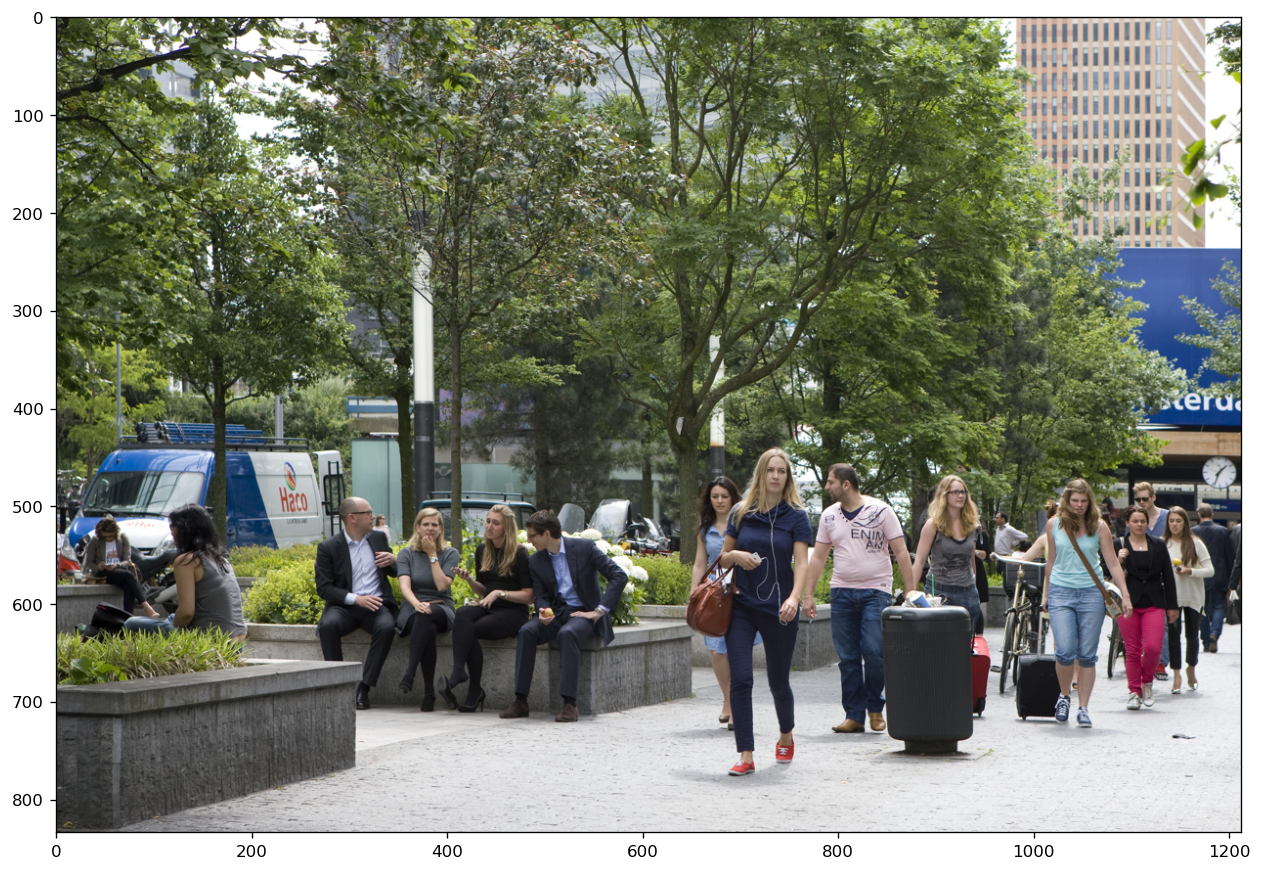

In [41]:
# or_image = Image.open(img_path)
img = restore_transform(img)
plt.figure(figsize=(1920/120, 1080/120), dpi=120)
plt.imshow(img)
plt.show()

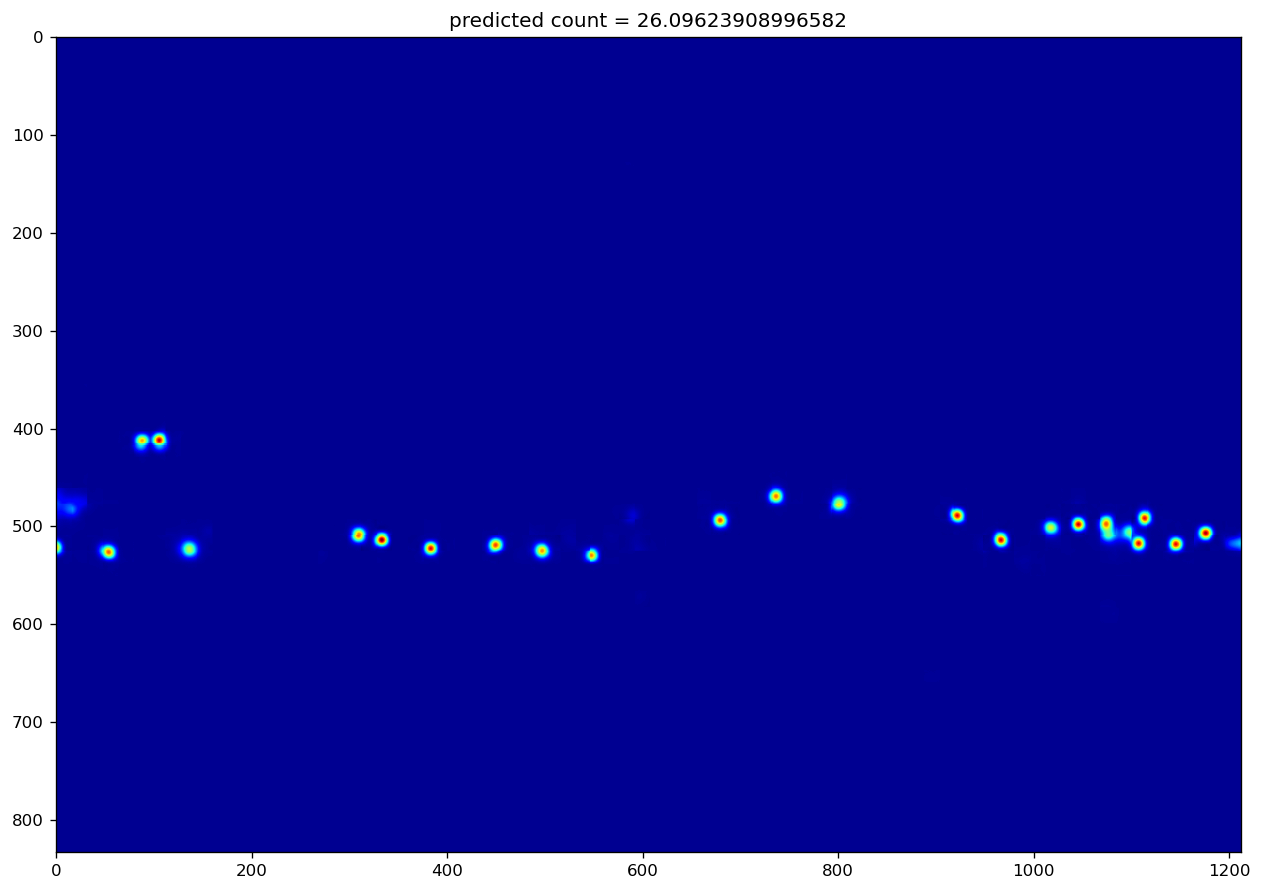

In [42]:
plt.figure(figsize=(1920/120, 1080/120), dpi=120)
plt.imshow(den, cmap=cm.jet)
plt.title(f'predicted count = {pred_cnt}')
plt.savefig('prediction2.jpg', dpi=120)
plt.show()

In [43]:
new_img = np.array(img)
new_den = np.array(den)

new_img[:, :, 0] = new_img[:, :, 0] + new_den * 100

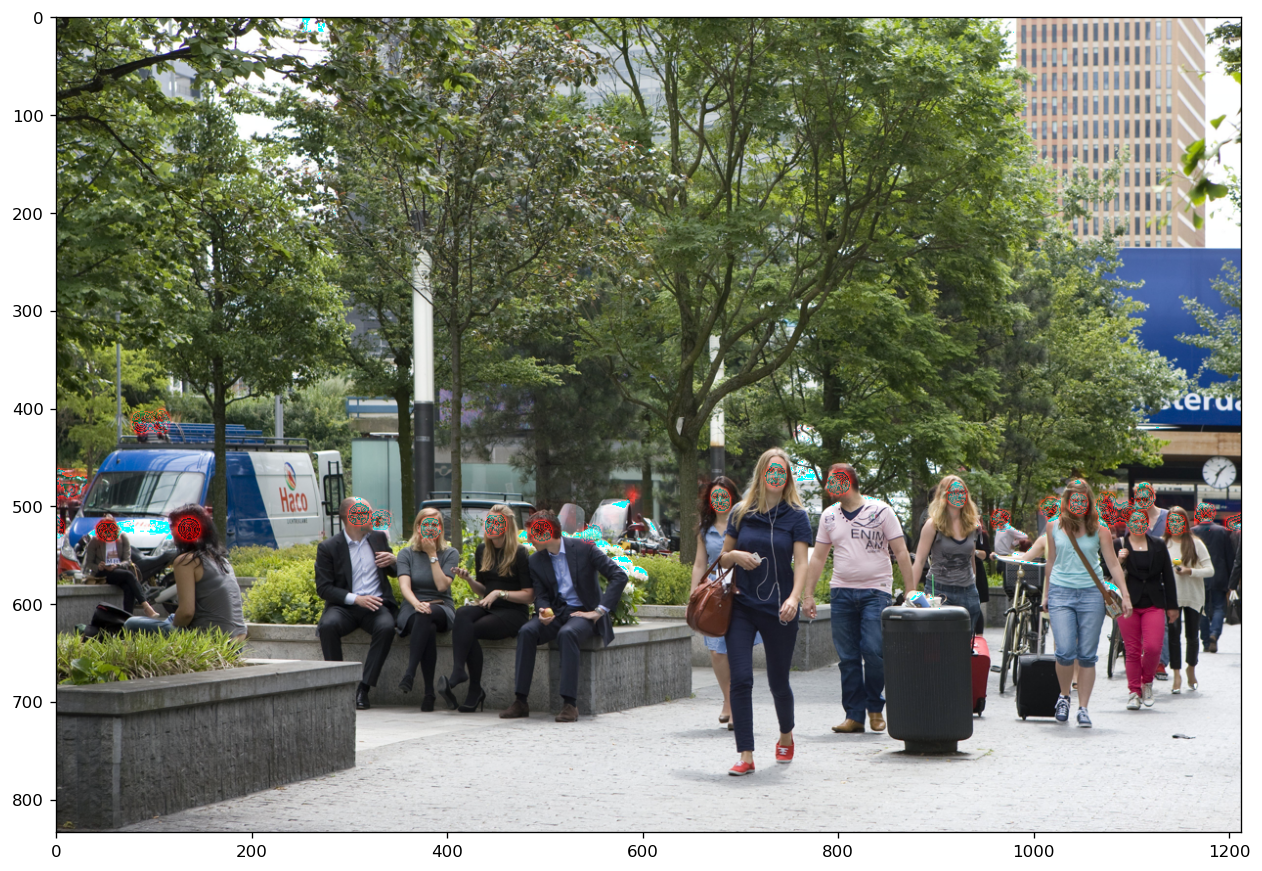

In [44]:
# or_image = Image.open(img_path)
plt.figure(figsize=(1920/120, 1080/120), dpi=120)
plt.imshow(new_img)
plt.show()